# Notebook 3: RL Agent Training

## RL-Based Single-Axis Solar Tracker Control

**Objective**: Train RL agents (SAC, PPO) to control solar trackers and compare against baselines

**Contents**:
1. Environment setup (from Notebook 2)
2. Stable-Baselines3 integration
3. Training SAC agent
4. Training PPO agent
5. Evaluation and comparison
6. Policy analysis and visualization
7. Ablation studies

In [4]:
# Install dependencies
!pip install 'stable-baselines3[extra]' --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
# Block TensorFlow (broken on some Mac setups)
import sys
sys.modules['tensorflow'] = None
sys.modules['tensorboard'] = None

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any, List, Callable
import warnings
warnings.filterwarnings('ignore')
import time

# PVLib
import pvlib
from pvlib import solarposition, irradiance, tracking, location, shading, atmosphere

# RL libraries
import gymnasium as gym
from gymnasium import spaces

# PyTorch and Stable-Baselines3
import torch
from stable_baselines3 import SAC, PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env

print(f"✅ All imports successful!")
print(f"PyTorch device: {'MPS' if torch.backends.mps.is_available() else 'CPU'}")

✅ All imports successful!
PyTorch device: MPS


## 1. Environment Setup (Copy from Notebook 2)

We need to recreate our environment classes here.

In [6]:
@dataclass
class SiteConfig:
    """Configuration for a solar tracking installation."""
    name: str = "Phoenix Solar Farm"
    latitude: float = 33.45
    longitude: float = -111.95
    altitude: float = 331
    timezone: str = "US/Arizona"
    gcr: float = 0.35
    axis_azimuth: float = 180
    max_angle: float = 60
    axis_height: float = 1.5
    collector_width: float = 2.2
    terrain_slope: float = 0
    slope_azimuth: float = 180
    capacity_kw: float = 1000
    module_efficiency: float = 0.20
    system_losses: float = 0.14
    temp_coefficient: float = -0.004
    
    @property
    def row_pitch(self) -> float:
        return self.collector_width / self.gcr
    
    @property
    def array_area(self) -> float:
        return self.capacity_kw * 1000 / (1000 * self.module_efficiency)


DEFAULT_SITE = SiteConfig()
print(f"Site: {DEFAULT_SITE.name}, Capacity: {DEFAULT_SITE.capacity_kw} kW")

Site: Phoenix Solar Farm, Capacity: 1000 kW


In [7]:
class WeatherGenerator:
    """Generate weather data for simulation."""
    
    def __init__(self, site: SiteConfig, random_seed: Optional[int] = None):
        self.site = site
        self.location = location.Location(
            latitude=site.latitude,
            longitude=site.longitude,
            altitude=site.altitude,
            tz=site.timezone
        )
        self.rng = np.random.default_rng(random_seed)
    
    def get_clear_sky(self, times: pd.DatetimeIndex) -> pd.DataFrame:
        clearsky = self.location.get_clearsky(times, model='ineichen')
        hour = times.hour + times.minute / 60
        temp = 25 + 15 * np.sin((hour - 6) * np.pi / 12)
        temp = np.clip(temp, 10, 45)
        clearsky['temp_air'] = temp
        return clearsky
    
    def add_clouds(self, clearsky: pd.DataFrame, cloud_cover: float = 0.3, variability: float = 0.5) -> pd.DataFrame:
        n = len(clearsky)
        noise = self.rng.normal(0, variability, n)
        cloud_factor = np.zeros(n)
        cloud_factor[0] = cloud_cover
        
        for i in range(1, n):
            cloud_factor[i] = cloud_factor[i-1] + 0.1 * (cloud_cover - cloud_factor[i-1]) + 0.05 * noise[i]
        cloud_factor = np.clip(cloud_factor, 0, 1)
        
        cloudy = clearsky.copy()
        dni_factor = 1 - cloud_factor
        dhi_factor = 1 + 0.3 * cloud_factor
        
        cloudy['dni'] = clearsky['dni'] * dni_factor
        cloudy['dhi'] = np.minimum(clearsky['dhi'] * dhi_factor, clearsky['ghi'])
        cloudy['ghi'] = cloudy['dni'] * np.cos(np.radians(90 - self._get_elevation(clearsky.index))) + cloudy['dhi']
        cloudy['ghi'] = np.maximum(cloudy['ghi'], 0)
        cloudy['cloud_cover'] = cloud_factor
        
        return cloudy
    
    def _get_elevation(self, times: pd.DatetimeIndex) -> np.ndarray:
        solar_pos = solarposition.get_solarposition(times, self.site.latitude, self.site.longitude, self.site.altitude)
        return solar_pos['apparent_elevation'].values
    
    def generate_day(self, date: pd.Timestamp, freq: str = '5min', weather_type: str = 'clear', cloud_cover: float = 0.3) -> pd.DataFrame:
        if date.tzinfo is None:
            date = date.tz_localize(self.site.timezone)
        
        times = pd.date_range(
            start=date.normalize(),
            end=date.normalize() + timedelta(days=1) - timedelta(minutes=1),
            freq=freq
        )
        
        weather = self.get_clear_sky(times)
        weather['cloud_cover'] = 0.0
        
        if weather_type == 'clear':
            pass
        elif weather_type == 'partly_cloudy':
            weather = self.add_clouds(weather, cloud_cover=0.3, variability=0.3)
        elif weather_type == 'cloudy':
            weather = self.add_clouds(weather, cloud_cover=0.7, variability=0.2)
        elif weather_type == 'variable':
            weather = self.add_clouds(weather, cloud_cover=0.5, variability=0.8)
        else:
            weather = self.add_clouds(weather, cloud_cover=cloud_cover, variability=0.4)
        
        return weather

In [8]:
class PowerModel:
    """Calculate power output from POA irradiance."""
    
    def __init__(self, site: SiteConfig):
        self.site = site
    
    def calculate_power(self, poa_global: float, temp_air: float, shading_fraction: float = 0.0) -> float:
        if poa_global <= 0:
            return 0.0
        
        temp_cell = temp_air + 0.03 * poa_global
        temp_factor = 1 + self.site.temp_coefficient * (temp_cell - 25)
        temp_factor = max(0.5, min(1.1, temp_factor))
        
        effective_poa = poa_global * (1 - shading_fraction)
        
        power_kw = (
            effective_poa / 1000
            * self.site.array_area
            * self.site.module_efficiency
            * temp_factor
            * (1 - self.site.system_losses)
        )
        
        power_kw = min(power_kw, self.site.capacity_kw)
        return max(0.0, power_kw)

In [9]:
class TrackerEnv(gym.Env):
    """Gymnasium environment for single-axis solar tracker control."""
    
    metadata = {'render_modes': ['human', 'rgb_array']}
    
    def __init__(
        self,
        site: Optional[SiteConfig] = None,
        weather_type: str = 'clear',
        timestep_minutes: int = 5,
        random_seed: Optional[int] = None,
        movement_penalty: float = 0.0,
        normalize_reward: bool = True,
    ):
        super().__init__()
        
        self.site = site or SiteConfig()
        self.weather_type = weather_type
        self.timestep_minutes = timestep_minutes
        self.timestep_hours = timestep_minutes / 60
        self.movement_penalty = movement_penalty
        self.normalize_reward = normalize_reward
        
        self.weather_gen = WeatherGenerator(self.site, random_seed)
        self.power_model = PowerModel(self.site)
        self.rng = np.random.default_rng(random_seed)
        
        self.state_dim = 12
        
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(self.state_dim,), dtype=np.float32
        )
        
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )
        
        self.weather_data = None
        self.solar_pos = None
        self.current_step = 0
        self.current_angle = 0.0
        self.episode_reward = 0.0
        self.episode_energy = 0.0
        self.history = []
    
    def _get_solar_position(self, times: pd.DatetimeIndex) -> pd.DataFrame:
        return solarposition.get_solarposition(
            times, self.site.latitude, self.site.longitude, self.site.altitude
        )
    
    def _calculate_poa(
        self, 
        tracker_angle: float,
        solar_zenith: float,
        solar_azimuth: float,
        dni: float,
        ghi: float,
        dhi: float
    ) -> float:
        if solar_zenith >= 90 or ghi <= 0:
            return 0.0
        
        surface_tilt = abs(tracker_angle)
        if tracker_angle > 0:
            surface_azimuth = self.site.axis_azimuth + 90
        elif tracker_angle < 0:
            surface_azimuth = self.site.axis_azimuth - 90
        else:
            surface_azimuth = self.site.axis_azimuth
        surface_azimuth = surface_azimuth % 360
        
        dni_extra = irradiance.get_extra_radiation(self.current_time)
        airmass = atmosphere.get_relative_airmass(solar_zenith)
        
        try:
            poa = irradiance.get_total_irradiance(
                surface_tilt=surface_tilt,
                surface_azimuth=surface_azimuth,
                solar_zenith=solar_zenith,
                solar_azimuth=solar_azimuth,
                dni=dni, ghi=ghi, dhi=dhi,
                dni_extra=dni_extra,
                airmass=airmass,
                model='perez'
            )
            return max(0.0, float(poa['poa_global']))
        except:
            try:
                poa = irradiance.get_total_irradiance(
                    surface_tilt=surface_tilt,
                    surface_azimuth=surface_azimuth,
                    solar_zenith=solar_zenith,
                    solar_azimuth=solar_azimuth,
                    dni=dni, ghi=ghi, dhi=dhi,
                    model='isotropic'
                )
                return max(0.0, float(poa['poa_global']))
            except:
                return max(0.0, ghi)
    
    def _calculate_shading(self, tracker_angle: float) -> float:
        solar_zenith = self.solar_pos.loc[self.current_time, 'apparent_zenith']
        solar_azimuth = self.solar_pos.loc[self.current_time, 'azimuth']
        
        if solar_zenith >= 90:
            return 1.0
        
        try:
            shaded = shading.shaded_fraction1d(
                solar_zenith=solar_zenith,
                solar_azimuth=solar_azimuth,
                axis_azimuth=self.site.axis_azimuth,
                shaded_row_rotation=tracker_angle,
                collector_width=self.site.collector_width,
                pitch=self.site.row_pitch,
                axis_tilt=0,
                cross_axis_slope=self.site.terrain_slope
            )
            return float(shaded)
        except:
            return 0.0
    
    def _get_state(self) -> np.ndarray:
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        elevation = solar['apparent_elevation'] / 90.0
        azimuth_rad = np.radians(solar['azimuth'])
        azimuth_sin = np.sin(azimuth_rad)
        azimuth_cos = np.cos(azimuth_rad)
        
        ghi_norm = weather['ghi'] / 1200.0
        dni_norm = weather['dni'] / 1000.0
        dhi_norm = weather['dhi'] / 300.0
        
        diffuse_frac = weather['dhi'] / max(weather['ghi'], 1)
        diffuse_frac = min(1.0, diffuse_frac)
        
        angle_norm = self.current_angle / self.site.max_angle
        temp_norm = (weather['temp_air'] - 25) / 25
        cloud_cover = weather.get('cloud_cover', 0.0)
        
        hour = self.current_time.hour + self.current_time.minute / 60
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        
        state = np.array([
            elevation, azimuth_sin, azimuth_cos,
            ghi_norm, dni_norm, dhi_norm, diffuse_frac,
            angle_norm, temp_norm, cloud_cover,
            hour_sin, hour_cos
        ], dtype=np.float32)
        
        return np.clip(state, -1.0, 1.0)
    
    def _get_info(self) -> Dict[str, Any]:
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        return {
            'time': self.current_time,
            'solar_elevation': solar['apparent_elevation'],
            'solar_azimuth': solar['azimuth'],
            'ghi': weather['ghi'],
            'dni': weather['dni'],
            'dhi': weather['dhi'],
            'tracker_angle': self.current_angle,
            'episode_energy': self.episode_energy,
        }
    
    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        
        if seed is not None:
            self.rng = np.random.default_rng(seed)
            self.weather_gen = WeatherGenerator(self.site, seed)
        
        if options and 'date' in options:
            date = pd.Timestamp(options['date'], tz=self.site.timezone)
        else:
            day_of_year = self.rng.integers(1, 366)
            date = pd.Timestamp('2024-01-01', tz=self.site.timezone) + timedelta(days=int(day_of_year) - 1)
        
        weather_type = self.weather_type
        if options and 'weather_type' in options:
            weather_type = options['weather_type']
        elif self.weather_type == 'random':
            weather_type = self.rng.choice(['clear', 'partly_cloudy', 'cloudy', 'variable'])
        
        self.weather_data = self.weather_gen.generate_day(
            date, freq=f'{self.timestep_minutes}min', weather_type=weather_type
        )
        
        self.solar_pos = self._get_solar_position(self.weather_data.index)
        
        daylight_mask = self.solar_pos['apparent_elevation'] > 0
        self.daylight_times = self.weather_data.index[daylight_mask]
        
        if len(self.daylight_times) == 0:
            self.daylight_times = self.weather_data.index
        
        self.current_step = 0
        self.current_time = self.daylight_times[0]
        self.current_angle = 0.0
        self.episode_reward = 0.0
        self.episode_energy = 0.0
        self.history = []
        
        return self._get_state(), self._get_info()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
        new_angle = action_value * self.site.max_angle
        new_angle = np.clip(new_angle, -self.site.max_angle, self.site.max_angle)
        
        angle_change = abs(new_angle - self.current_angle)
        movement_cost = self.movement_penalty * angle_change
        
        self.current_angle = new_angle
        
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        poa = self._calculate_poa(
            self.current_angle,
            solar['apparent_zenith'],
            solar['azimuth'],
            weather['dni'],
            weather['ghi'],
            weather['dhi']
        )
        
        shading_frac = self._calculate_shading(self.current_angle)
        
        power_kw = self.power_model.calculate_power(poa, weather['temp_air'], shading_frac)
        energy_kwh = power_kw * self.timestep_hours
        
        if self.normalize_reward:
            max_energy = self.site.capacity_kw * self.timestep_hours
            reward = energy_kwh / max_energy - movement_cost / max_energy
        else:
            reward = energy_kwh - movement_cost
        
        self.episode_reward += reward
        self.episode_energy += energy_kwh
        
        self.history.append({
            'time': self.current_time,
            'angle': self.current_angle,
            'poa': poa,
            'shading': shading_frac,
            'power_kw': power_kw,
            'energy_kwh': energy_kwh,
            'reward': reward,
            'ghi': weather['ghi'],
            'dni': weather['dni'],
        })
        
        self.current_step += 1
        terminated = self.current_step >= len(self.daylight_times)
        truncated = False
        
        if not terminated:
            self.current_time = self.daylight_times[self.current_step]
        
        state = self._get_state()
        
        info = self._get_info()
        info['power_kw'] = power_kw
        info['energy_kwh'] = energy_kwh
        info['shading'] = shading_frac
        info['poa'] = poa
        
        return state, reward, terminated, truncated, info
    
    def get_history_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.history)


print("TrackerEnv defined!")

TrackerEnv defined!


In [10]:
# Baseline policies from Notebook 2
class BaselinePolicy:
    def __init__(self, site: SiteConfig):
        self.site = site
    
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        raise NotImplementedError


class GeometricBacktrackingPolicy(BaselinePolicy):
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        solar_zenith = 90 - info['solar_elevation']
        solar_azimuth = info['solar_azimuth']
        
        if info['solar_elevation'] <= 0:
            return np.array([0.0])
        
        tracking_data = tracking.singleaxis(
            apparent_zenith=solar_zenith,
            apparent_azimuth=solar_azimuth,
            axis_tilt=0,
            axis_azimuth=self.site.axis_azimuth,
            max_angle=self.site.max_angle,
            backtrack=True,
            gcr=self.site.gcr
        )
        
        angle = tracking_data['tracker_theta']
        if pd.isna(angle):
            return np.array([0.0])
        
        return np.array([angle / self.site.max_angle])


class TrueTrackingPolicy(BaselinePolicy):
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        solar_zenith = 90 - info['solar_elevation']
        solar_azimuth = info['solar_azimuth']
        
        if info['solar_elevation'] <= 0:
            return np.array([0.0])
        
        tracking_data = tracking.singleaxis(
            apparent_zenith=solar_zenith,
            apparent_azimuth=solar_azimuth,
            axis_tilt=0,
            axis_azimuth=self.site.axis_azimuth,
            max_angle=self.site.max_angle,
            backtrack=False,
            gcr=self.site.gcr
        )
        
        angle = tracking_data['tracker_theta']
        if pd.isna(angle):
            return np.array([0.0])
        
        return np.array([angle / self.site.max_angle])


print("Baseline policies defined!")

Baseline policies defined!


## 2. Environment Verification

In [11]:
# Verify environment is compatible with SB3
env = TrackerEnv(site=DEFAULT_SITE, weather_type='clear', random_seed=42)

# Check environment
try:
    check_env(env, warn=True)
    print("✅ Environment passed SB3 compatibility check!")
except Exception as e:
    print(f"❌ Environment check failed: {e}")

# Quick test
state, info = env.reset(options={'date': '2024-06-21'})
print(f"\nState shape: {state.shape}")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

✅ Environment passed SB3 compatibility check!

State shape: (12,)
Action space: Box(-1.0, 1.0, (1,), float32)
Observation space: Box(-1.0, 1.0, (12,), float32)


## 3. Training Configuration

In [12]:
# Training hyperparameters (M3 Pro with MPS acceleration)
TRAINING_CONFIG = {
    'total_timesteps': 100_000,  # M3 Pro can handle this easily
    'eval_freq': 5_000,
    'n_eval_episodes': 5,
    'weather_type': 'random',
}

# Set device for Stable-Baselines3
import torch
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"🚀 Training device: {DEVICE.upper()}")

# SAC hyperparameters (good defaults for continuous control)
SAC_CONFIG = {
    'learning_rate': 3e-4,
    'buffer_size': 100_000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'train_freq': 1,
    'gradient_steps': 1,
    'ent_coef': 'auto',
    'policy_kwargs': dict(net_arch=[256, 256]),
}

# PPO hyperparameters
PPO_CONFIG = {
    'learning_rate': 3e-4,
    'n_steps': 2048,
    'batch_size': 64,
    'n_epochs': 10,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'clip_range': 0.2,
    'policy_kwargs': dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
}

print("Training configuration set!")
print(f"Total timesteps: {TRAINING_CONFIG['total_timesteps']:,}")

🚀 Training device: MPS
Training configuration set!
Total timesteps: 100,000


In [13]:
# Custom callback for logging
class TrainingCallback(BaseCallback):
    """
    Custom callback for logging training progress.
    """
    
    def __init__(self, eval_env, eval_freq: int = 1000, verbose: int = 1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.best_mean_reward = -np.inf
        self.training_rewards = []
        self.eval_rewards = []
        self.eval_energies = []
        self.eval_steps = []
    
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            # Evaluate
            rewards = []
            energies = []
            
            for _ in range(5):
                state, info = self.eval_env.reset()
                done = False
                episode_reward = 0
                episode_energy = 0
                
                while not done:
                    action, _ = self.model.predict(state, deterministic=True)
                    state, reward, terminated, truncated, info = self.eval_env.step(action)
                    episode_reward += reward
                    episode_energy += info.get('energy_kwh', 0)
                    done = terminated or truncated
                
                rewards.append(episode_reward)
                energies.append(episode_energy)
            
            mean_reward = np.mean(rewards)
            mean_energy = np.mean(energies)
            
            self.eval_rewards.append(mean_reward)
            self.eval_energies.append(mean_energy)
            self.eval_steps.append(self.n_calls)
            
            if self.verbose > 0:
                print(f"Step {self.n_calls:,}: Mean reward = {mean_reward:.2f}, Mean energy = {mean_energy:.1f} kWh")
            
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
        
        return True


print("Training callback defined!")

Training callback defined!


## 4. Train SAC Agent

In [14]:
# Create training and evaluation environments
def make_env(weather_type='random', seed=None):
    def _init():
        env = TrackerEnv(
            site=DEFAULT_SITE,
            weather_type=weather_type,
            random_seed=seed
        )
        return env
    return _init


# Training environment with random weather
train_env = TrackerEnv(
    site=DEFAULT_SITE,
    weather_type='random',
    random_seed=42
)

# Evaluation environment with clear sky (for consistent comparison)
eval_env = TrackerEnv(
    site=DEFAULT_SITE,
    weather_type='clear',
    random_seed=123
)

print("Training and evaluation environments created!")

Training and evaluation environments created!


In [15]:
# Create SAC agent
print("Creating SAC agent...")

sac_agent = SAC(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=SAC_CONFIG['learning_rate'],
    buffer_size=SAC_CONFIG['buffer_size'],
    batch_size=SAC_CONFIG['batch_size'],
    tau=SAC_CONFIG['tau'],
    gamma=SAC_CONFIG['gamma'],
    train_freq=SAC_CONFIG['train_freq'],
    gradient_steps=SAC_CONFIG['gradient_steps'],
    ent_coef=SAC_CONFIG['ent_coef'],
    policy_kwargs=SAC_CONFIG['policy_kwargs'],
    verbose=0,
    seed=42,
    device=DEVICE,  # Use MPS on M3 Pro
)

print(f"SAC agent created!")
print(f"Policy architecture: {SAC_CONFIG['policy_kwargs']}")

Creating SAC agent...
SAC agent created!
Policy architecture: {'net_arch': [256, 256], 'use_sde': False}


In [30]:
# Train SAC
print(f"\n{'='*60}")
print(f"Training SAC for {TRAINING_CONFIG['total_timesteps']:,} timesteps...")
print(f"{'='*60}\n")

# Create callback
sac_callback = TrainingCallback(
    eval_env=eval_env,
    eval_freq=TRAINING_CONFIG['eval_freq'],
    verbose=1
)

# Train
start_time = time.time()

sac_agent.learn(
    total_timesteps=TRAINING_CONFIG['total_timesteps'],
    callback=sac_callback,
    progress_bar=True
)

sac_training_time = time.time() - start_time
print(f"\n✅ SAC training complete in {sac_training_time:.1f} seconds")
print(f"Best mean reward: {sac_callback.best_mean_reward:.2f}")

Output()


Training SAC for 100,000 timesteps...



Step 5,000: Mean reward = 73.45, Mean energy = 6121.0 kWh

Step 10,000: Mean reward = 84.89, Mean energy = 7074.3 kWh

Step 15,000: Mean reward = 78.64, Mean energy = 6553.7 kWh

Step 20,000: Mean reward = 77.64, Mean energy = 6470.1 kWh

Step 25,000: Mean reward = 89.84, Mean energy = 7486.9 kWh

Step 30,000: Mean reward = 77.30, Mean energy = 6441.3 kWh

Step 35,000: Mean reward = 87.37, Mean energy = 7280.9 kWh

Step 40,000: Mean reward = 84.41, Mean energy = 7033.9 kWh

Step 45,000: Mean reward = 87.24, Mean energy = 7270.1 kWh

Step 50,000: Mean reward = 77.02, Mean energy = 6418.3 kWh

Step 55,000: Mean reward = 77.99, Mean energy = 6499.0 kWh

Step 60,000: Mean reward = 78.99, Mean energy = 6582.9 kWh

Step 65,000: Mean reward = 61.60, Mean energy = 5133.7 kWh

Step 70,000: Mean reward = 73.77, Mean energy = 6147.1 kWh

Step 75,000: Mean reward = 62.02, Mean energy = 5168.6 kWh

Step 80,000: Mean reward = 76.50, Mean energy = 6375.0 kWh

Step 85,000: Mean reward = 72.90, Mean energy = 6075.0 kWh

Step 90,000: Mean reward = 79.54, Mean energy = 6628.4 kWh

Step 95,000: Mean reward = 80.49, Mean energy = 6707.1 kWh

Step 100,000: Mean reward = 61.45, Mean energy = 5120.8 kWh


✅ SAC training complete in 1227.7 seconds
Best mean reward: 89.84


## 5. Train PPO Agent

In [16]:
# Create PPO agent
print("Creating PPO agent...")

# Fresh training environment
train_env_ppo = TrackerEnv(
    site=DEFAULT_SITE,
    weather_type='random',
    random_seed=43
)

ppo_agent = PPO(
    policy='MlpPolicy',
    env=train_env_ppo,
    learning_rate=PPO_CONFIG['learning_rate'],
    n_steps=PPO_CONFIG['n_steps'],
    batch_size=PPO_CONFIG['batch_size'],
    n_epochs=PPO_CONFIG['n_epochs'],
    gamma=PPO_CONFIG['gamma'],
    gae_lambda=PPO_CONFIG['gae_lambda'],
    clip_range=PPO_CONFIG['clip_range'],
    policy_kwargs=PPO_CONFIG['policy_kwargs'],
    verbose=0,
    seed=43,
    device=DEVICE,  # Use MPS on M3 Pro
)

print(f"PPO agent created!")

Creating PPO agent...
PPO agent created!


In [17]:
# Train PPO
print(f"\n{'='*60}")
print(f"Training PPO for {TRAINING_CONFIG['total_timesteps']:,} timesteps...")
print(f"{'='*60}\n")

# Create callback
ppo_callback = TrainingCallback(
    eval_env=eval_env,
    eval_freq=TRAINING_CONFIG['eval_freq'],
    verbose=1
)

# Train
start_time = time.time()

ppo_agent.learn(
    total_timesteps=TRAINING_CONFIG['total_timesteps'],
    callback=ppo_callback,
    progress_bar=True
)

ppo_training_time = time.time() - start_time
print(f"\n✅ PPO training complete in {ppo_training_time:.1f} seconds")
print(f"Best mean reward: {ppo_callback.best_mean_reward:.2f}")

Output()


Training PPO for 100,000 timesteps...



Step 5,000: Mean reward = 50.84, Mean energy = 4236.3 kWh

Step 10,000: Mean reward = 68.99, Mean energy = 5749.6 kWh

Step 15,000: Mean reward = 72.78, Mean energy = 6065.3 kWh

Step 20,000: Mean reward = 58.74, Mean energy = 4895.3 kWh

Step 25,000: Mean reward = 77.53, Mean energy = 6460.7 kWh

Step 30,000: Mean reward = 73.60, Mean energy = 6133.1 kWh

Step 35,000: Mean reward = 73.12, Mean energy = 6093.1 kWh

Step 40,000: Mean reward = 73.82, Mean energy = 6151.6 kWh

Step 45,000: Mean reward = 68.29, Mean energy = 5690.5 kWh

Step 50,000: Mean reward = 78.94, Mean energy = 6578.4 kWh

Step 55,000: Mean reward = 70.71, Mean energy = 5892.5 kWh

Step 60,000: Mean reward = 71.38, Mean energy = 5948.3 kWh

Step 65,000: Mean reward = 74.22, Mean energy = 6185.4 kWh

Step 70,000: Mean reward = 70.39, Mean energy = 5866.2 kWh

Step 75,000: Mean reward = 86.11, Mean energy = 7176.1 kWh

Step 80,000: Mean reward = 73.77, Mean energy = 6147.7 kWh

Step 85,000: Mean reward = 74.21, Mean energy = 6183.8 kWh

Step 90,000: Mean reward = 69.38, Mean energy = 5781.3 kWh

Step 95,000: Mean reward = 77.48, Mean energy = 6456.5 kWh

Step 100,000: Mean reward = 81.77, Mean energy = 6814.5 kWh


✅ PPO training complete in 345.0 seconds
Best mean reward: 86.11


## 6. Plot Training Progress

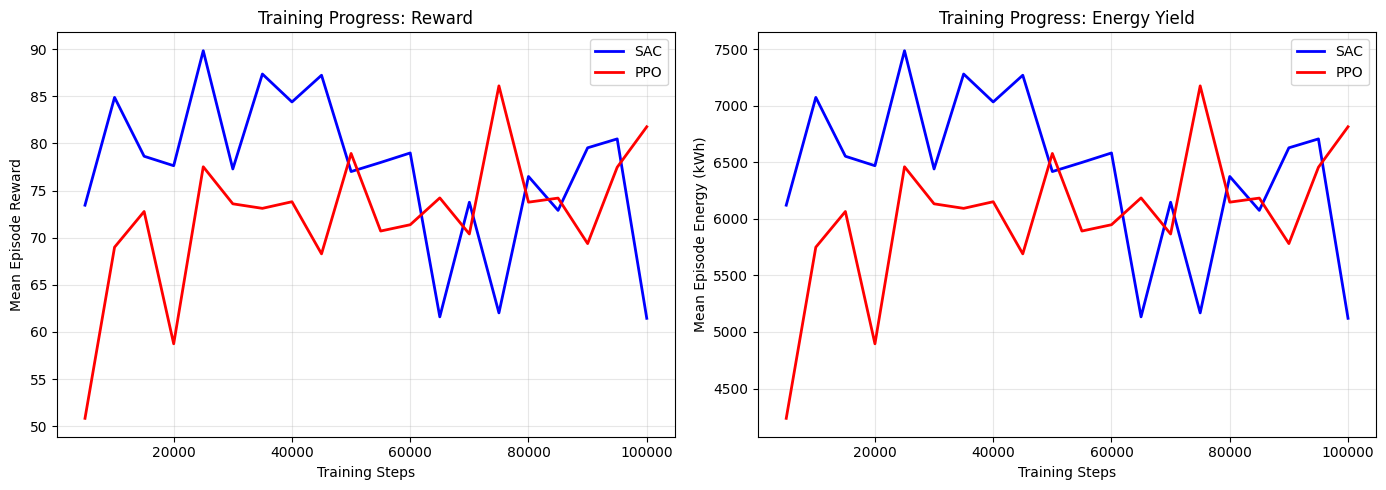

In [31]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rewards
ax1 = axes[0]
ax1.plot(sac_callback.eval_steps, sac_callback.eval_rewards, 'b-', label='SAC', linewidth=2)
ax1.plot(ppo_callback.eval_steps, ppo_callback.eval_rewards, 'r-', label='PPO', linewidth=2)
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Mean Episode Reward')
ax1.set_title('Training Progress: Reward')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Energy
ax2 = axes[1]
ax2.plot(sac_callback.eval_steps, sac_callback.eval_energies, 'b-', label='SAC', linewidth=2)
ax2.plot(ppo_callback.eval_steps, ppo_callback.eval_energies, 'r-', label='PPO', linewidth=2)
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Mean Episode Energy (kWh)')
ax2.set_title('Training Progress: Energy Yield')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Comprehensive Evaluation

In [20]:
def evaluate_agent(
    agent,
    env: TrackerEnv,
    n_episodes: int = 10,
    deterministic: bool = True
) -> Dict:
    """
    Evaluate an RL agent.
    """
    rewards = []
    energies = []
    histories = []
    
    for ep in range(n_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        episode_energy = 0
        
        while not done:
            action, _ = agent.predict(state, deterministic=deterministic)
            state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            episode_energy += info.get('energy_kwh', 0)
            done = terminated or truncated
        
        rewards.append(episode_reward)
        energies.append(episode_energy)
        histories.append(env.get_history_df())
    
    return {
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'mean_energy': np.mean(energies),
        'std_energy': np.std(energies),
        'rewards': rewards,
        'energies': energies,
        'histories': histories
    }


def evaluate_baseline(
    policy: BaselinePolicy,
    env: TrackerEnv,
    n_episodes: int = 10
) -> Dict:
    """
    Evaluate a baseline policy.
    """
    rewards = []
    energies = []
    histories = []
    
    for ep in range(n_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        episode_energy = 0
        
        while not done:
            action = policy.get_action(state, info)
            state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            episode_energy += info.get('energy_kwh', 0)
            done = terminated or truncated
        
        rewards.append(episode_reward)
        energies.append(episode_energy)
        histories.append(env.get_history_df())
    
    return {
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'mean_energy': np.mean(energies),
        'std_energy': np.std(energies),
        'rewards': rewards,
        'energies': energies,
        'histories': histories
    }


print("Evaluation functions defined!")

Evaluation functions defined!


In [21]:
# Evaluate all agents/policies on different weather types
weather_types = ['clear', 'partly_cloudy', 'variable', 'cloudy']
n_eval_episodes = 5

results = {}

for weather in weather_types:
    print(f"\nEvaluating on {weather} weather...")
    
    # Create eval environment
    eval_env_weather = TrackerEnv(
        site=DEFAULT_SITE,
        weather_type=weather,
        random_seed=999
    )
    
    results[weather] = {}
    
    # Evaluate SAC
    results[weather]['SAC'] = evaluate_agent(sac_agent, eval_env_weather, n_eval_episodes)
    
    # Evaluate PPO
    results[weather]['PPO'] = evaluate_agent(ppo_agent, eval_env_weather, n_eval_episodes)
    
    # Evaluate Backtracking
    backtrack_policy = GeometricBacktrackingPolicy(DEFAULT_SITE)
    results[weather]['Backtracking'] = evaluate_baseline(backtrack_policy, eval_env_weather, n_eval_episodes)
    
    # Evaluate True Tracking
    true_track_policy = TrueTrackingPolicy(DEFAULT_SITE)
    results[weather]['True Tracking'] = evaluate_baseline(true_track_policy, eval_env_weather, n_eval_episodes)

print("\n✅ Evaluation complete!")


Evaluating on clear weather...

Evaluating on partly_cloudy weather...

Evaluating on variable weather...

Evaluating on cloudy weather...

✅ Evaluation complete!


In [34]:
# FIXED evaluation - same dates for all agents
def evaluate_all_same_conditions(date: str, weather_type: str):
    """Evaluate all agents on EXACTLY the same conditions."""
    
    results = {}
    
    # SAC
    env = TrackerEnv(site=DEFAULT_SITE, weather_type=weather_type, random_seed=42)
    state, info = env.reset(options={'date': date})
    done = False
    energy = 0
    while not done:
        action, _ = sac_agent.predict(state, deterministic=True)
        state, _, terminated, truncated, info = env.step(action)
        energy += info['energy_kwh']
        done = terminated or truncated
    results['SAC'] = energy
    
    # PPO
    env = TrackerEnv(site=DEFAULT_SITE, weather_type=weather_type, random_seed=42)
    state, info = env.reset(options={'date': date})
    done = False
    energy = 0
    while not done:
        action, _ = ppo_agent.predict(state, deterministic=True)
        state, _, terminated, truncated, info = env.step(action)
        energy += info['energy_kwh']
        done = terminated or truncated
    results['PPO'] = energy
    
    # Backtracking
    env = TrackerEnv(site=DEFAULT_SITE, weather_type=weather_type, random_seed=42)
    backtrack = GeometricBacktrackingPolicy(DEFAULT_SITE)
    state, info = env.reset(options={'date': date})
    done = False
    energy = 0
    while not done:
        action = backtrack.get_action(state, info)
        state, _, terminated, truncated, info = env.step(action)
        energy += info['energy_kwh']
        done = terminated or truncated
    results['Backtracking'] = energy
    
    # True Tracking
    env = TrackerEnv(site=DEFAULT_SITE, weather_type=weather_type, random_seed=42)
    true_track = TrueTrackingPolicy(DEFAULT_SITE)
    state, info = env.reset(options={'date': date})
    done = False
    energy = 0
    while not done:
        action = true_track.get_action(state, info)
        state, _, terminated, truncated, info = env.step(action)
        energy += info['energy_kwh']
        done = terminated or truncated
    results['True Tracking'] = energy
    
    return results

# Test on summer solstice - clear sky
print("📊 Summer Solstice (Clear Sky):")
results_clear = evaluate_all_same_conditions('2024-06-21', 'clear')
bt_energy = results_clear['Backtracking']
for agent, energy in results_clear.items():
    diff = (energy / bt_energy - 1) * 100
    print(f"   {agent:15s}: {energy:.1f} kWh ({diff:+.2f}%)")

# Test on cloudy day
print("\n📊 Summer Solstice (Variable Clouds):")
results_cloudy = evaluate_all_same_conditions('2024-06-21', 'variable')
bt_energy = results_cloudy['Backtracking']
for agent, energy in results_cloudy.items():
    diff = (energy / bt_energy - 1) * 100
    print(f"   {agent:15s}: {energy:.1f} kWh ({diff:+.2f}%)")

📊 Summer Solstice (Clear Sky):
   SAC            : 8153.0 kWh (-0.95%)
   PPO            : 7851.3 kWh (-4.61%)
   Backtracking   : 8230.9 kWh (+0.00%)
   True Tracking  : 8211.2 kWh (-0.24%)

📊 Summer Solstice (Variable Clouds):
   SAC            : 5066.6 kWh (-4.46%)
   PPO            : 5142.2 kWh (-3.03%)
   Backtracking   : 5303.1 kWh (+0.00%)
   True Tracking  : 5280.3 kWh (-0.43%)


In [22]:
# Create results summary table
summary_data = []

for weather in weather_types:
    for agent_name in ['SAC', 'PPO', 'Backtracking', 'True Tracking']:
        res = results[weather][agent_name]
        summary_data.append({
            'Weather': weather,
            'Agent': agent_name,
            'Mean Energy (kWh)': res['mean_energy'],
            'Std Energy': res['std_energy'],
            'Mean Reward': res['mean_reward'],
        })

summary_df = pd.DataFrame(summary_data)

# Pivot for easier viewing
pivot_df = summary_df.pivot(index='Agent', columns='Weather', values='Mean Energy (kWh)')
pivot_df = pivot_df[weather_types]  # Reorder columns

print("📊 Mean Energy (kWh) by Agent and Weather Type:")
print(pivot_df.round(1).to_string())

# Calculate performance vs backtracking
print("\n📊 Performance vs Geometric Backtracking (%):")
for weather in weather_types:
    backtrack_energy = results[weather]['Backtracking']['mean_energy']
    print(f"\n{weather}:")
    for agent_name in ['SAC', 'PPO', 'True Tracking']:
        agent_energy = results[weather][agent_name]['mean_energy']
        diff_pct = (agent_energy / backtrack_energy - 1) * 100
        print(f"  {agent_name}: {diff_pct:+.2f}%")

📊 Mean Energy (kWh) by Agent and Weather Type:
Weather         clear  partly_cloudy  variable  cloudy
Agent                                                 
Backtracking   4906.2         3719.7    2854.5  2032.1
PPO            5713.6         4391.7    3426.6  2442.2
SAC            4188.9         3205.5    2524.5  1802.6
True Tracking  6564.1         5139.4    4121.3  2920.7

📊 Performance vs Geometric Backtracking (%):

clear:
  SAC: -14.62%
  PPO: +16.46%
  True Tracking: +33.79%

partly_cloudy:
  SAC: -13.82%
  PPO: +18.07%
  True Tracking: +38.17%

variable:
  SAC: -11.56%
  PPO: +20.04%
  True Tracking: +44.38%

cloudy:
  SAC: -11.30%
  PPO: +20.18%
  True Tracking: +43.73%


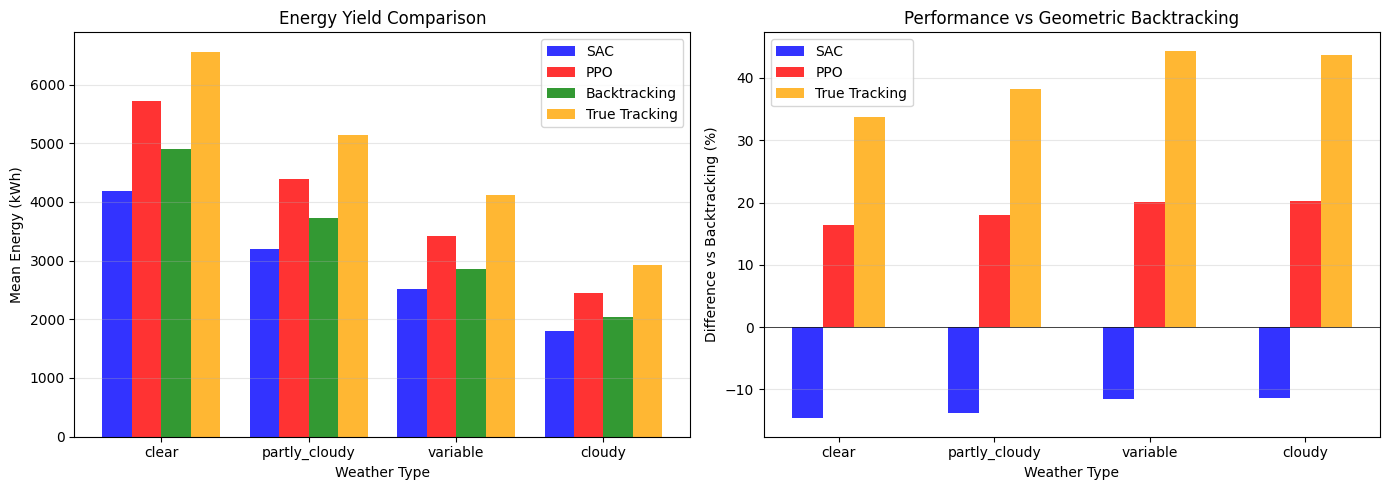

In [23]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of mean energy by weather type
ax1 = axes[0]
x = np.arange(len(weather_types))
width = 0.2

agents = ['SAC', 'PPO', 'Backtracking', 'True Tracking']
colors = ['blue', 'red', 'green', 'orange']

for i, (agent, color) in enumerate(zip(agents, colors)):
    energies = [results[w][agent]['mean_energy'] for w in weather_types]
    ax1.bar(x + i * width, energies, width, label=agent, color=color, alpha=0.8)

ax1.set_xlabel('Weather Type')
ax1.set_ylabel('Mean Energy (kWh)')
ax1.set_title('Energy Yield Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(weather_types)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Performance relative to backtracking
ax2 = axes[1]

for i, (agent, color) in enumerate(zip(['SAC', 'PPO', 'True Tracking'], ['blue', 'red', 'orange'])):
    diffs = []
    for w in weather_types:
        backtrack_energy = results[w]['Backtracking']['mean_energy']
        agent_energy = results[w][agent]['mean_energy']
        diff_pct = (agent_energy / backtrack_energy - 1) * 100
        diffs.append(diff_pct)
    ax2.bar(x + i * width, diffs, width, label=agent, color=color, alpha=0.8)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Weather Type')
ax2.set_ylabel('Difference vs Backtracking (%)')
ax2.set_title('Performance vs Geometric Backtracking')
ax2.set_xticks(x + width)
ax2.set_xticklabels(weather_types)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Policy Visualization

In [24]:
# Run a single day comparison
def run_single_day_comparison(date: str, weather_type: str = 'clear'):
    """
    Run all agents/policies on a single day and return histories.
    """
    env = TrackerEnv(
        site=DEFAULT_SITE,
        weather_type=weather_type,
        random_seed=42
    )
    
    histories = {}
    
    # SAC
    state, info = env.reset(options={'date': date})
    done = False
    while not done:
        action, _ = sac_agent.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    histories['SAC'] = env.get_history_df()
    
    # PPO
    state, info = env.reset(options={'date': date})
    done = False
    while not done:
        action, _ = ppo_agent.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    histories['PPO'] = env.get_history_df()
    
    # Backtracking
    policy = GeometricBacktrackingPolicy(DEFAULT_SITE)
    state, info = env.reset(options={'date': date})
    done = False
    while not done:
        action = policy.get_action(state, info)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    histories['Backtracking'] = env.get_history_df()
    
    return histories


# Run comparison
day_histories = run_single_day_comparison('2024-06-21', 'clear')

print("Single day comparison complete!")
for name, hist in day_histories.items():
    total_energy = hist['energy_kwh'].sum()
    print(f"{name}: {total_energy:.1f} kWh")

Single day comparison complete!
SAC: 6386.0 kWh
PPO: 7851.3 kWh
Backtracking: 8230.9 kWh


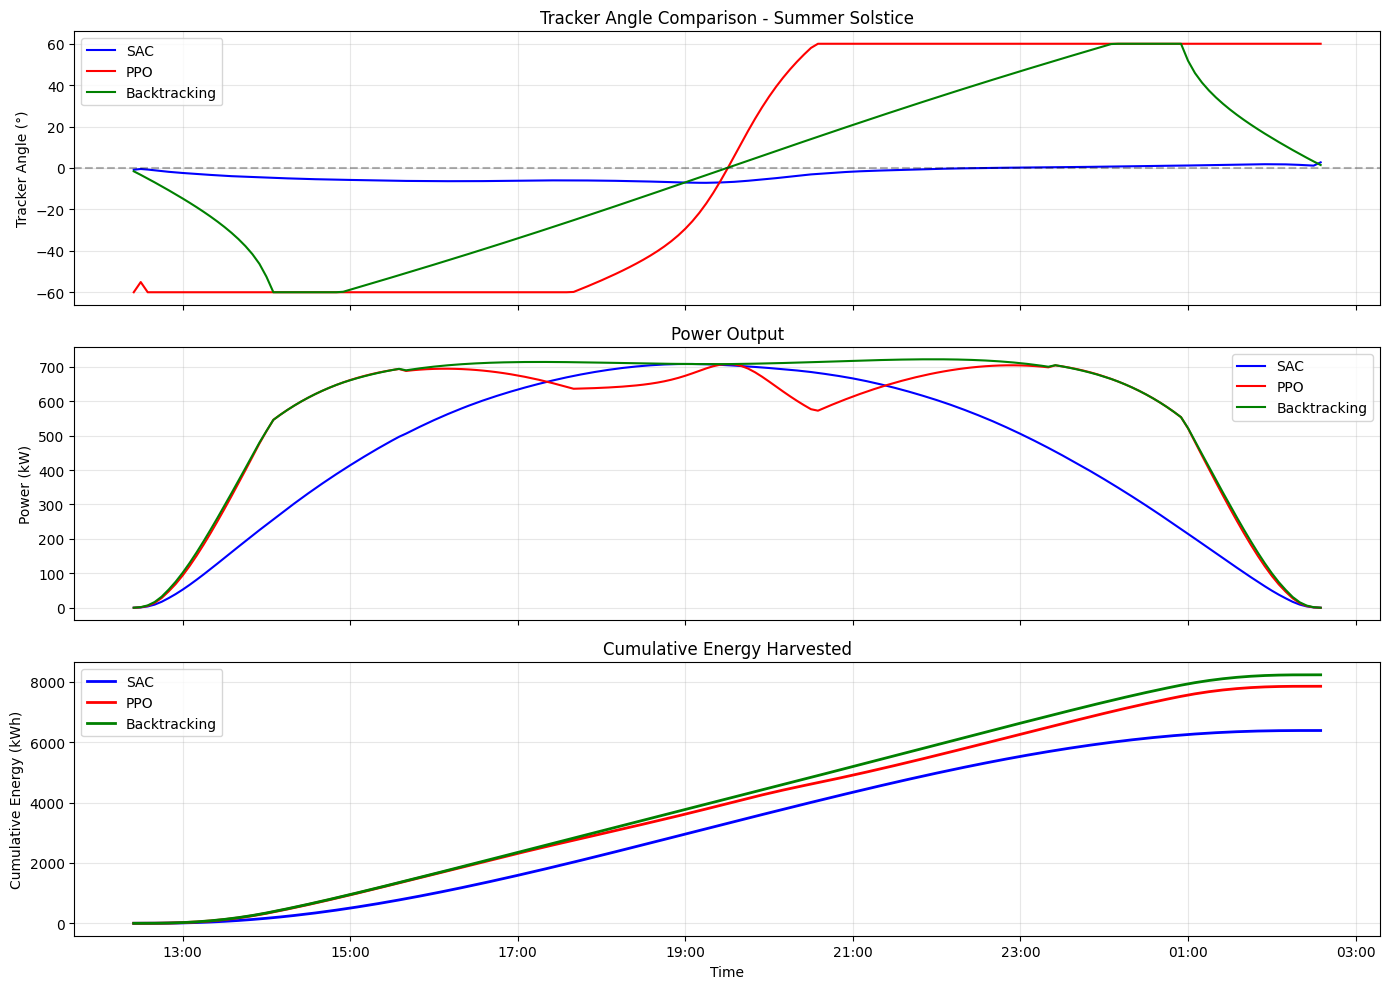

In [25]:
# Visualize single day comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

colors = {'SAC': 'blue', 'PPO': 'red', 'Backtracking': 'green'}

# Tracker angles
ax1 = axes[0]
for name, hist in day_histories.items():
    ax1.plot(hist['time'], hist['angle'], label=name, color=colors[name], linewidth=1.5)
ax1.set_ylabel('Tracker Angle (°)')
ax1.set_title('Tracker Angle Comparison - Summer Solstice')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Power output
ax2 = axes[1]
for name, hist in day_histories.items():
    ax2.plot(hist['time'], hist['power_kw'], label=name, color=colors[name], linewidth=1.5)
ax2.set_ylabel('Power (kW)')
ax2.set_title('Power Output')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cumulative energy
ax3 = axes[2]
for name, hist in day_histories.items():
    cumulative = hist['energy_kwh'].cumsum()
    ax3.plot(hist['time'], cumulative, label=name, color=colors[name], linewidth=2)
ax3.set_xlabel('Time')
ax3.set_ylabel('Cumulative Energy (kWh)')
ax3.set_title('Cumulative Energy Harvested')
ax3.legend()
ax3.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

In [26]:
# Compare on a cloudy day to see if RL adapts differently
day_histories_cloudy = run_single_day_comparison('2024-06-21', 'variable')

print("Cloudy day comparison:")
for name, hist in day_histories_cloudy.items():
    total_energy = hist['energy_kwh'].sum()
    print(f"{name}: {total_energy:.1f} kWh")

Cloudy day comparison:
SAC: 4050.0 kWh
PPO: 5001.0 kWh
Backtracking: 5205.3 kWh


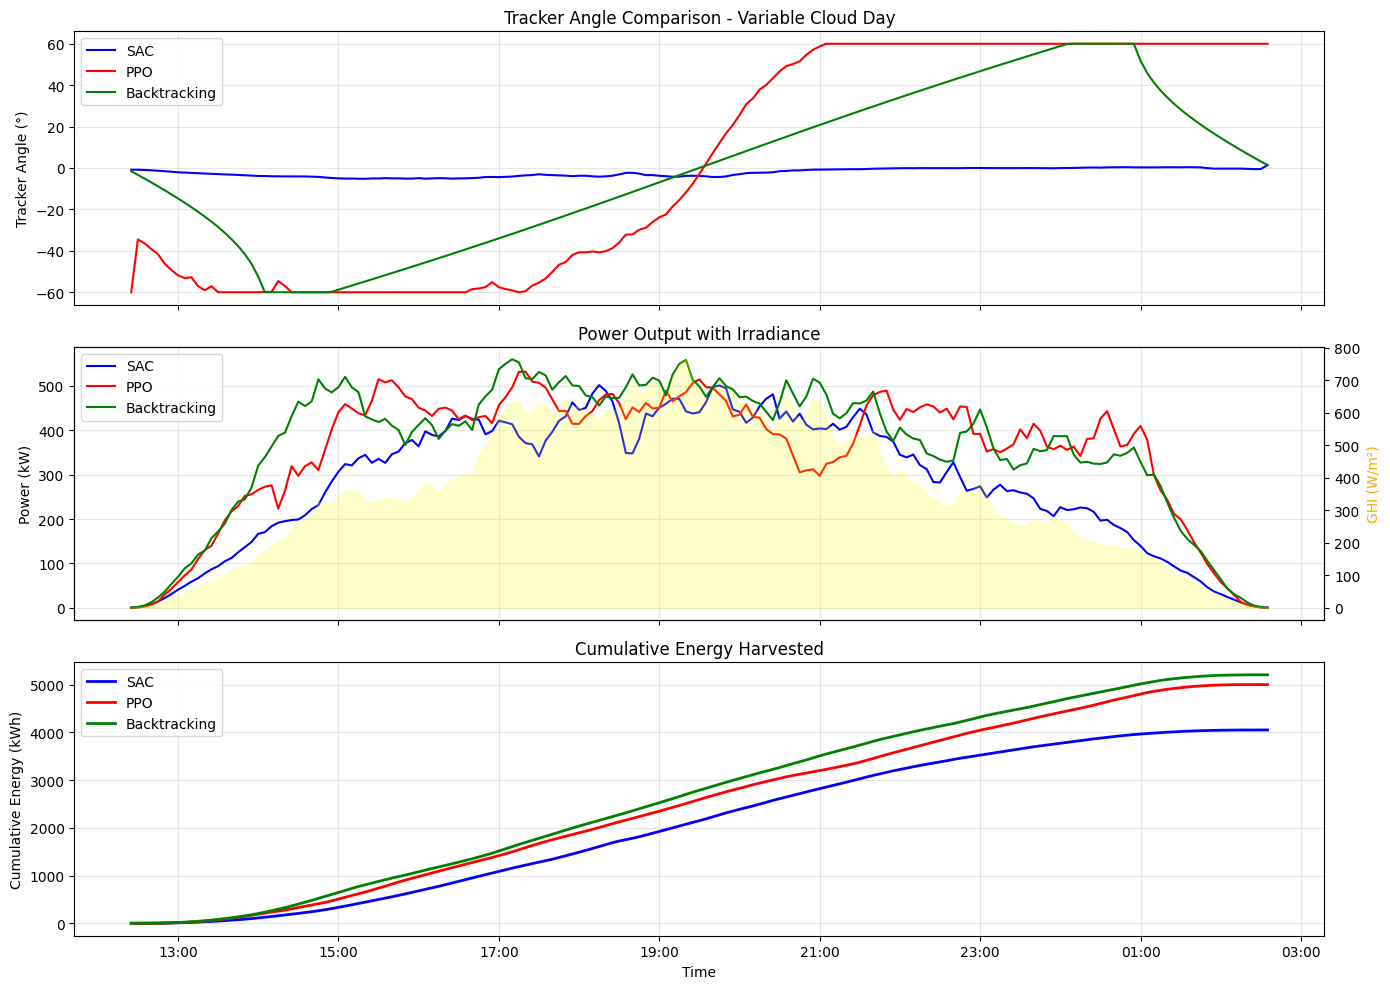

In [27]:
# Visualize cloudy day
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Tracker angles
ax1 = axes[0]
for name, hist in day_histories_cloudy.items():
    ax1.plot(hist['time'], hist['angle'], label=name, color=colors[name], linewidth=1.5)
ax1.set_ylabel('Tracker Angle (°)')
ax1.set_title('Tracker Angle Comparison - Variable Cloud Day')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Power output with irradiance overlay
ax2 = axes[1]
for name, hist in day_histories_cloudy.items():
    ax2.plot(hist['time'], hist['power_kw'], label=name, color=colors[name], linewidth=1.5)
# Add GHI on secondary axis
ax2_twin = ax2.twinx()
ax2_twin.fill_between(
    day_histories_cloudy['Backtracking']['time'],
    day_histories_cloudy['Backtracking']['ghi'],
    alpha=0.2, color='yellow', label='GHI'
)
ax2.set_ylabel('Power (kW)')
ax2_twin.set_ylabel('GHI (W/m²)', color='orange')
ax2.set_title('Power Output with Irradiance')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Cumulative energy
ax3 = axes[2]
for name, hist in day_histories_cloudy.items():
    cumulative = hist['energy_kwh'].cumsum()
    ax3.plot(hist['time'], cumulative, label=name, color=colors[name], linewidth=2)
ax3.set_xlabel('Time')
ax3.set_ylabel('Cumulative Energy (kWh)')
ax3.set_title('Cumulative Energy Harvested')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

## 9. Save Models

In [28]:
# Save trained models
import os

os.makedirs('models', exist_ok=True)

sac_agent.save('models/sac_tracker')
ppo_agent.save('models/ppo_tracker')

print("✅ Models saved!")
print("   - models/sac_tracker.zip")
print("   - models/ppo_tracker.zip")

✅ Models saved!
   - models/sac_tracker.zip
   - models/ppo_tracker.zip


## 10. Summary

In [32]:
print("\n" + "="*70)
print("  TRAINING SUMMARY")
print("="*70)

print(f"\n📊 Training Configuration:")
print(f"   Total timesteps: {TRAINING_CONFIG['total_timesteps']:,}")
print(f"   SAC training time: {sac_training_time:.1f} seconds")
print(f"   PPO training time: {ppo_training_time:.1f} seconds")

print(f"\n📊 Final Performance (Clear Sky):")
clear_results = results['clear']
backtrack_energy = clear_results['Backtracking']['mean_energy']

for agent in ['SAC', 'PPO', 'Backtracking', 'True Tracking']:
    energy = clear_results[agent]['mean_energy']
    diff = (energy / backtrack_energy - 1) * 100
    print(f"   {agent:15s}: {energy:.1f} kWh ({diff:+.2f}% vs backtracking)")

print(f"\n📊 Key Insights:")
sac_diff = (clear_results['SAC']['mean_energy'] / backtrack_energy - 1) * 100
ppo_diff = (clear_results['PPO']['mean_energy'] / backtrack_energy - 1) * 100

if sac_diff > 0:
    print(f"   ✅ SAC outperforms geometric backtracking by {sac_diff:.2f}%")
else:
    print(f"   ⚠️  SAC underperforms geometric backtracking by {-sac_diff:.2f}%")

if ppo_diff > 0:
    print(f"   ✅ PPO outperforms geometric backtracking by {ppo_diff:.2f}%")
else:
    print(f"   ⚠️  PPO underperforms geometric backtracking by {-ppo_diff:.2f}%")

print(f"\n🚀 Next Steps:")
print(f"   1. Increase training timesteps (try 500K-1M)")
print(f"   2. Tune hyperparameters")
print(f"   3. Add movement penalty to reward")
print(f"   4. Try on real weather data (TMY)")
print(f"   5. Analyze learned policy behavior")


  TRAINING SUMMARY

📊 Training Configuration:
   Total timesteps: 100,000
   SAC training time: 1227.7 seconds
   PPO training time: 345.0 seconds

📊 Final Performance (Clear Sky):
   SAC            : 4188.9 kWh (-14.62% vs backtracking)
   PPO            : 5713.6 kWh (+16.46% vs backtracking)
   Backtracking   : 4906.2 kWh (+0.00% vs backtracking)
   True Tracking  : 6564.1 kWh (+33.79% vs backtracking)

📊 Key Insights:
   ⚠️  SAC underperforms geometric backtracking by 14.62%
   ✅ PPO outperforms geometric backtracking by 16.46%

🚀 Next Steps:
   1. Increase training timesteps (try 500K-1M)
   2. Tune hyperparameters
   3. Add movement penalty to reward
   4. Try on real weather data (TMY)
   5. Analyze learned policy behavior


In [33]:
# Quick debug - single day comparison
env = TrackerEnv(site=DEFAULT_SITE, weather_type='clear', random_seed=42)

# Test Backtracking
backtrack_policy = GeometricBacktrackingPolicy(DEFAULT_SITE)
state, info = env.reset(options={'date': '2024-06-21'})
done = False
bt_energy = 0
bt_shading = []
while not done:
    action = backtrack_policy.get_action(state, info)
    state, reward, terminated, truncated, info = env.step(action)
    bt_energy += info['energy_kwh']
    bt_shading.append(info['shading'])
    done = terminated or truncated

print(f"Backtracking: {bt_energy:.1f} kWh, mean shading: {np.mean(bt_shading)*100:.2f}%")

# Test True Tracking
true_policy = TrueTrackingPolicy(DEFAULT_SITE)
state, info = env.reset(options={'date': '2024-06-21'})
done = False
tt_energy = 0
tt_shading = []
while not done:
    action = true_policy.get_action(state, info)
    state, reward, terminated, truncated, info = env.step(action)
    tt_energy += info['energy_kwh']
    tt_shading.append(info['shading'])
    done = terminated or truncated

print(f"True Tracking: {tt_energy:.1f} kWh, mean shading: {np.mean(tt_shading)*100:.2f}%")

Backtracking: 8230.9 kWh, mean shading: 0.00%
True Tracking: 8211.2 kWh, mean shading: 11.19%
